## Import Packages

In [1]:
import os
from pathlib import Path
import logging
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

from datetime import datetime
import exchange_calendars as xc

# for Parquet I/O
import pyarrow as pa
import pyarrow.parquet as pq


## Inspect Data

In [2]:
# Define raw file path
raw_path = Path("../../01_Data_Raw/Carbon_Markets/GDEA_raw.csv")

# Load CSV
df_raw = pd.read_csv(
    raw_path,
    header = 0,
    encoding = "gb18030"
)

In [3]:
df_raw.head()


,指标名称,广东:收盘价:碳排放权配额(GDEA),广东:成交均价:碳排放权配额(GDEA),广东:当日成交量:碳排放权配额(GDEA),广东:当日成交额:碳排放权配额(GDEA),广东:当日成交额:碳排放权配额(GDEA).1,广东:累计成交额:碳排放权配额(GDEA)
0,频率,日,日,日,日,日,日
1,单位,元/吨,元/吨,吨,元,元,元
2,指标ID,S6301317,S6301318,S6301319,S6301320,S6301320,S6301322
3,来源,广州碳排放权交易所,广州碳排放权交易所,广州碳排放权交易所,广州碳排放权交易所,广州碳排放权交易所,广州碳排放权交易所
4,2025/5/6,38.02,38.02,933,35472.6,35472.6,5.77157259664E9


In [4]:
df_raw.tail(4)

,指标名称,广东:收盘价:碳排放权配额(GDEA),广东:成交均价:碳排放权配额(GDEA),广东:当日成交量:碳排放权配额(GDEA),广东:当日成交额:碳排放权配额(GDEA),广东:当日成交额:碳排放权配额(GDEA).1,广东:累计成交额:碳排放权配额(GDEA)
4159,2013/12/20,60,60,100,6000,6000,NaN
4160,2013/12/19,60.17,60.166626,120029,7221740,7221740,NaN
4161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4162,数据来源：Wind,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Inspect shape and columns
print(f"Shape: {df_raw.shape}")
print("Column list with indices:")
for idx, col in enumerate(df_raw.columns):
    print(f"{idx}: {col}")

# Summary of dtypes and non-null counts
print("\nInfo:")
print(df_raw.info())

# Missing values per column
print("\nMissing values per column:")
print(df_raw.isnull().sum())

# Check unique dates
date_col = df_raw.columns[0]
print(f"\nUnique dates in {date_col}:")
print(df_raw[date_col].unique())

Shape: (4163, 7)
Column list with indices:
0: 指标名称
1: 广东:收盘价:碳排放权配额(GDEA)
2: 广东:成交均价:碳排放权配额(GDEA)
3: 广东:当日成交量:碳排放权配额(GDEA)
4: 广东:当日成交额:碳排放权配额(GDEA)
5: 广东:当日成交额:碳排放权配额(GDEA).1
6: 广东:累计成交额:碳排放权配额(GDEA)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4163 entries, 0 to 4162
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   指标名称                     4162 non-null   object
 1   广东:收盘价:碳排放权配额(GDEA)      2479 non-null   object
 2   广东:成交均价:碳排放权配额(GDEA)     2481 non-null   object
 3   广东:当日成交量:碳排放权配额(GDEA)    2481 non-null   object
 4   广东:当日成交额:碳排放权配额(GDEA)    2481 non-null   object
 5   广东:当日成交额:碳排放权配额(GDEA).1  2481 non-null   object
 6   广东:累计成交额:碳排放权配额(GDEA)    3143 non-null   object
dtypes: object(7)
memory usage: 227.8+ KB
None

Missing values per column:
指标名称                          1
广东:收盘价:碳排放权配额(GDEA)        1684
广东:成交均价:碳排放权配额(GDEA)       1682
广东:当日成交量:碳排放权配额(GDEA)      1682
广东:当日成交

## Make Data Structure Clean
Remove Meta Data, drop duplicate column, rename columns

In [6]:
# Drop first 4 rows, last 2 footer rows
df = df_raw.iloc[4:-2]

In [7]:
df = df.copy()

# Drop the duplicate column by name (instead of by index) and without inplace
dup_col = df.columns[5]
df = df.drop(columns=[dup_col])

# Rename columns using a mapping dict
col_map = {
    df.columns[0]: "date",
    df.columns[1]: "close",
    df.columns[2]: "vwap",
    df.columns[3]: "volume_tons",
    df.columns[4]: "turnover_cny",
    df.columns[5]: "cum_turnover_cny"
}
df = df.rename(columns=col_map)

# Sort by date
df = df.sort_values(by="date", ascending=True)

# Verify
df.head(10)


,date,close,vwap,volume_tons,turnover_cny,cum_turnover_cny
4160,2013/12/19,60.17,60.166626,120029,7221740,NaN
4159,2013/12/20,60,60,100,6000,NaN
4158,2013/12/21,NaN,NaN,NaN,NaN,NaN
4157,2013/12/22,NaN,NaN,NaN,NaN,NaN
4156,2013/12/23,NaN,NaN,NaN,NaN,7227740
4155,2013/12/24,NaN,NaN,NaN,NaN,7227740
4154,2013/12/25,NaN,NaN,NaN,NaN,7227740
4153,2013/12/26,NaN,NaN,NaN,NaN,7227740
4152,2013/12/27,NaN,NaN,NaN,NaN,7227740
4151,2013/12/28,NaN,NaN,NaN,NaN,NaN


In [8]:
df.dtypes

date                object
close               object
vwap                object
volume_tons         object
turnover_cny        object
cum_turnover_cny    object
dtype: object

## Parsing Data Types

In [9]:
# `date` column to datetime
df["date"] = pd.to_datetime(df["date"], format="%Y/%m/%d")

# all other to numeric
numeric_cols = [
    "close",
    "vwap",
    "volume_tons",
    "turnover_cny",
    "cum_turnover_cny"
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Set `date` as index
df = df.set_index("date").sort_index(ascending=True)

df.head(10)

,close,vwap,volume_tons,turnover_cny,cum_turnover_cny
date,,,,,
2013-12-19,60.17,60.166626,120029.0,7221740.0,NaN
2013-12-20,60.00,60.000000,100.0,6000.0,NaN
2013-12-21,NaN,NaN,NaN,NaN,NaN
2013-12-22,NaN,NaN,NaN,NaN,NaN
2013-12-23,NaN,NaN,NaN,NaN,7227740.0
2013-12-24,NaN,NaN,NaN,NaN,7227740.0
2013-12-25,NaN,NaN,NaN,NaN,7227740.0
2013-12-26,NaN,NaN,NaN,NaN,7227740.0
2013-12-27,NaN,NaN,NaN,NaN,7227740.0


### Temporary Data Storage
Temporary save to current directory in case of unexpected errors

In [10]:
# save to parquet
df.to_parquet("01_GDEA_Interim1.parquet")

In [11]:
# Restore from parquet
df_restored = pd.read_parquet("01_GDEA_Interim1.parquet")
df_restored.head(10)

,close,vwap,volume_tons,turnover_cny,cum_turnover_cny
date,,,,,
2013-12-19,60.17,60.166626,120029.0,7221740.0,NaN
2013-12-20,60.00,60.000000,100.0,6000.0,NaN
2013-12-21,NaN,NaN,NaN,NaN,NaN
2013-12-22,NaN,NaN,NaN,NaN,NaN
2013-12-23,NaN,NaN,NaN,NaN,7227740.0
2013-12-24,NaN,NaN,NaN,NaN,7227740.0
2013-12-25,NaN,NaN,NaN,NaN,7227740.0
2013-12-26,NaN,NaN,NaN,NaN,7227740.0
2013-12-27,NaN,NaN,NaN,NaN,7227740.0


## Further Inspection on Data Quality

### Remove Pre-mature phase via rolling trade frequency

Use a 60-day rolling trade frequency to decide the mature start date
We take the first time when the 60-day rolling trade frequency is greater than 50% as the mature start date

The smoothed 60-day rolling trade frequency is calculated by a 20-day moving average of the 60-day rolling trade frequency
For plotting purposes only

In [12]:
# Ensure df_sorted exists and is indexed by DatetimeIndex

# binary flag: 1 if any volume on that calendar day
trade_flag = (
    df["volume_tons"].notna()   # True where at least one trade
    .astype(int)
)

# 60-day rolling trade frequency, plus a 20-day smoothing
rolling60 = trade_flag.rolling(60, min_periods=60).mean()
rolling60_smth = rolling60.rolling(20, min_periods=1).mean()  # extra smoothing

# detect first date where freq ≥ 50 %
mature_start = rolling60[rolling60 >= 0.50].index.min()

# window limits for zoom plot (first 3 calendar-years after launch)
start_date = rolling60.first_valid_index()
end_3y = start_date + pd.DateOffset(years=3)

print("=== KEY DATES ===")
print("Launch (first valid index):", start_date.date())
print("Mature-start threshold:", mature_start.date())
print("Zoom window ends:", end_3y.date())

=== KEY DATES ===
Launch (first valid index): 2014-02-16
Mature-start threshold: 2014-06-27
Zoom window ends: 2017-02-16


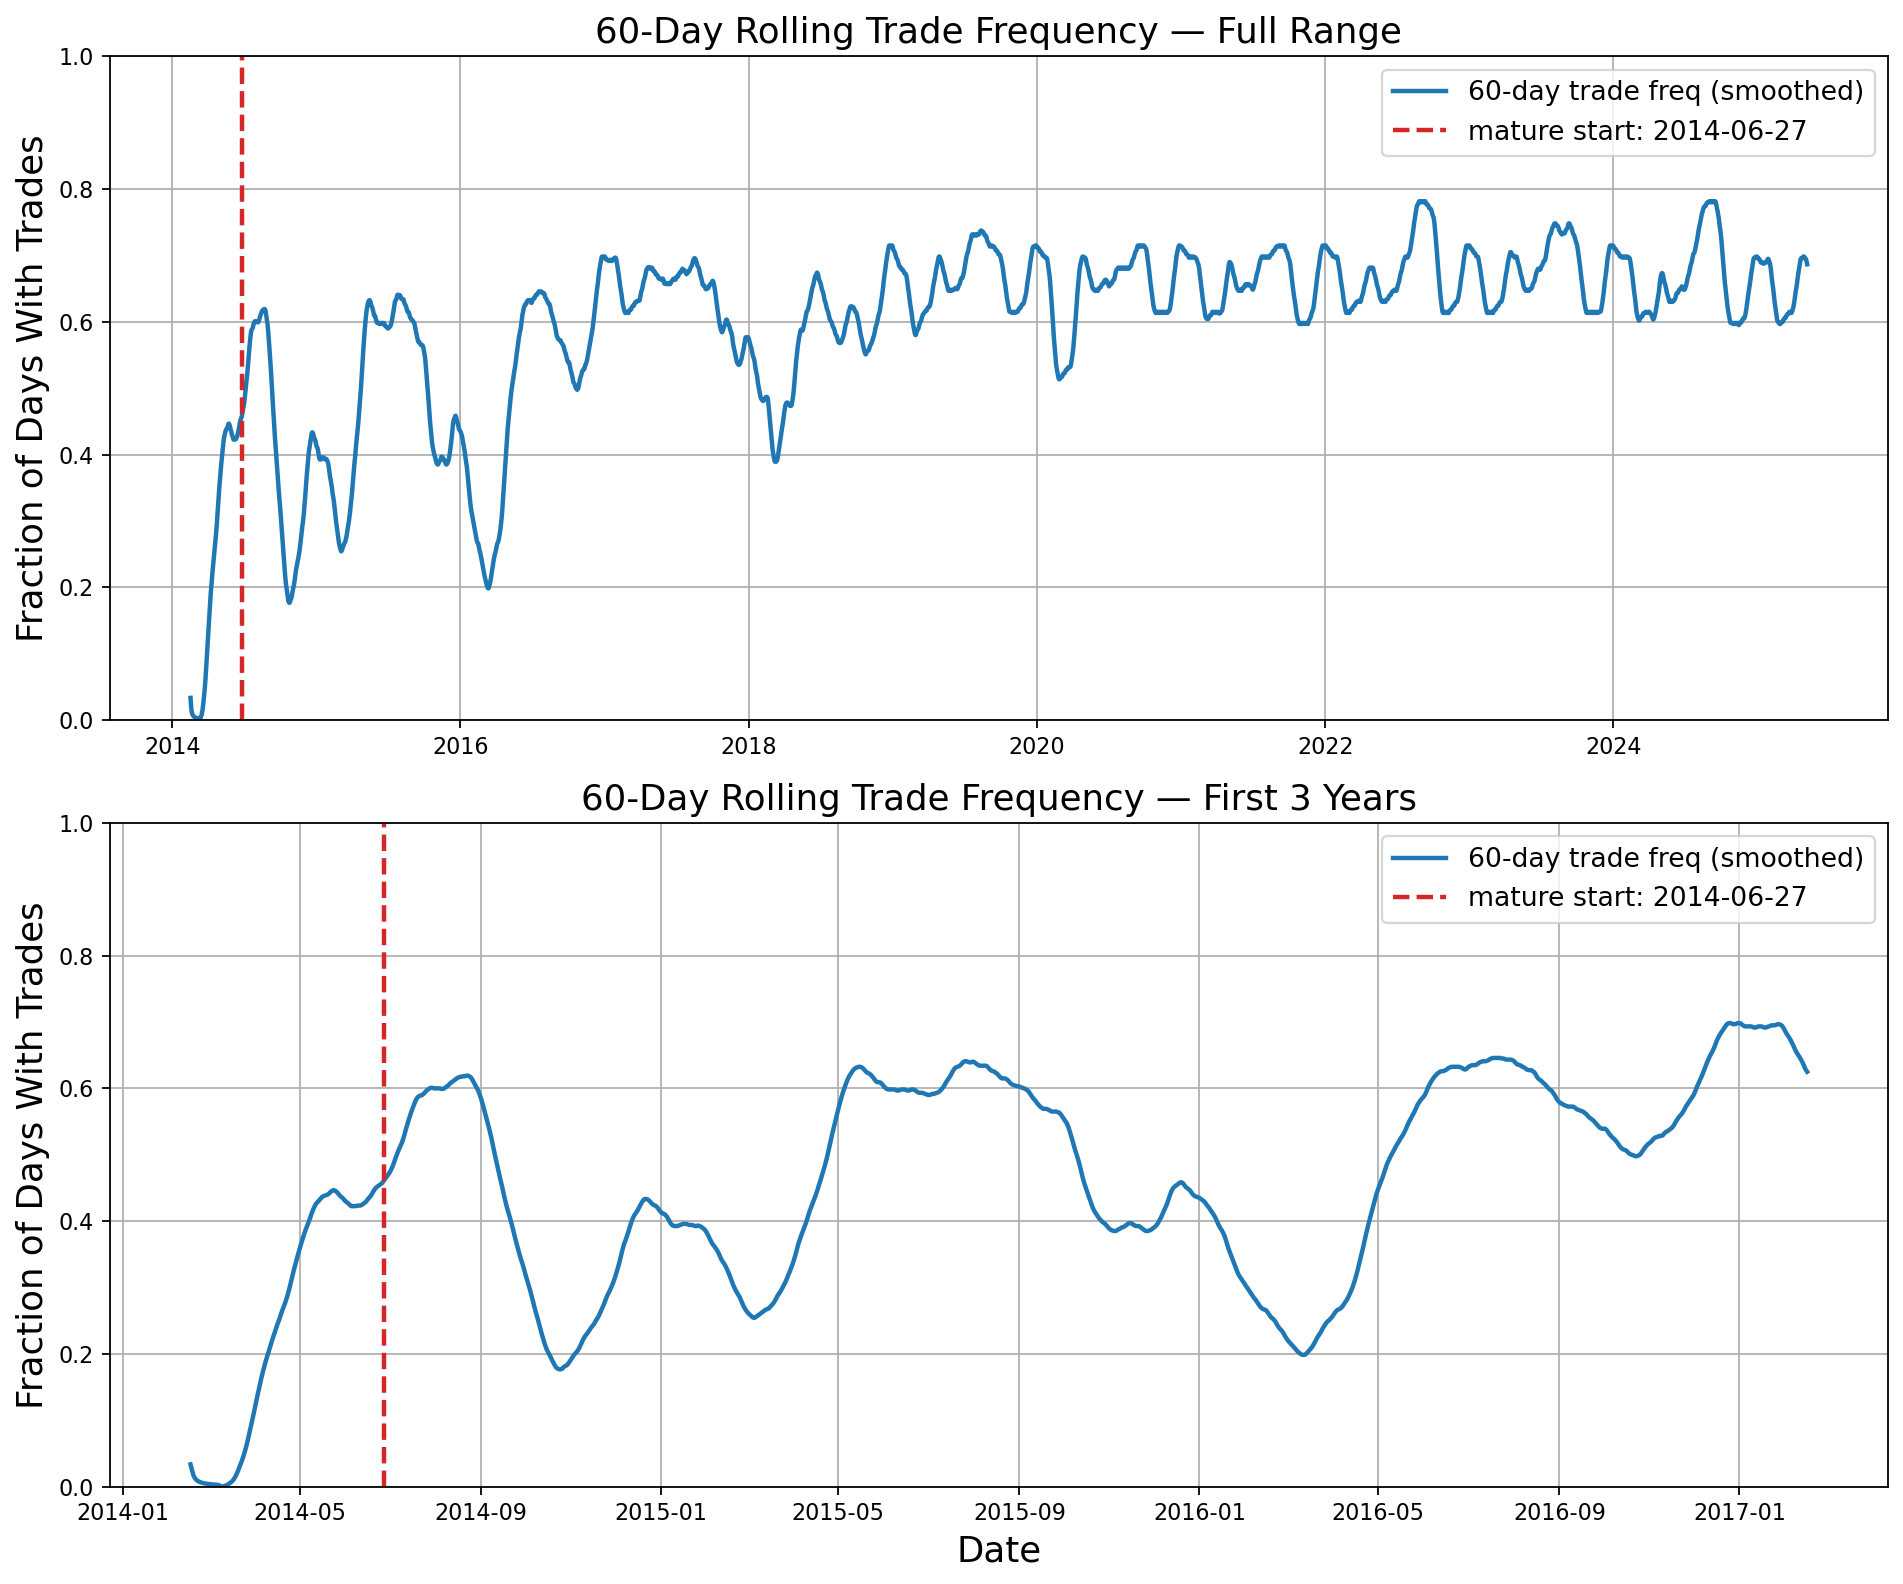

In [13]:
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 10), dpi=160, sharex=False
)

# Top row: full timeline
axes[0].plot(
    rolling60_smth.index,
    rolling60_smth.values,
    lw=2, 
    label="60-day trade freq (smoothed)"
)
axes[0].axvline(
    mature_start,
    color="#d62728",
    ls="--",
    lw=2,
    label=f"mature start: {mature_start.date()}"
)
axes[0].set_title("60-Day Rolling Trade Frequency — Full Range", fontsize=16)
axes[0].set_ylabel("Fraction of Days With Trades", fontsize=16)
axes[0].set_ylim(0, 1)
axes[0].grid(alpha=1)
axes[0].legend(fontsize=12)

# Bottom row: first 3 years
mask = (rolling60_smth.index >= start_date) & (rolling60_smth.index <= end_3y)
axes[1].plot(
    rolling60_smth.index[mask],
    rolling60_smth.values[mask],
    lw=2,
    label="60-day trade freq (smoothed)"
)
axes[1].axvline(
    mature_start,
    color="#d62728",
    ls="--",
    lw=2,
    label=f"mature start: {mature_start.date()}"
)
axes[1].set_title("60-Day Rolling Trade Frequency — First 3 Years", fontsize=16)
axes[1].set_ylabel("Fraction of Days With Trades", fontsize=16)
axes[1].set_xlabel("Date", fontsize=16)
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=1)
axes[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


In [14]:
# Only keep mature phase data
df = df[df.index >= mature_start]
df.head(3)

,close,vwap,volume_tons,turnover_cny,cum_turnover_cny
date,,,,,
2014-06-27,68.0,68.0,6.0,408.0,34705338.01
2014-06-28,NaN,NaN,NaN,NaN,NaN
2014-06-29,NaN,NaN,NaN,NaN,NaN


In [15]:
# temporary save to parquet
df.to_parquet("01_GDEA_Interim2.parquet")
# restore
df_restored = pd.read_parquet("01_GDEA_Interim2.parquet")
df_restored.head(3)


,close,vwap,volume_tons,turnover_cny,cum_turnover_cny
date,,,,,
2014-06-27,68.0,68.0,6.0,408.0,34705338.01
2014-06-28,NaN,NaN,NaN,NaN,NaN
2014-06-29,NaN,NaN,NaN,NaN,NaN


### Inspect Missing Values

In [16]:
df_restored.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3967 entries, 2014-06-27 to 2025-05-06
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             2419 non-null   float64
 1   vwap              2421 non-null   float64
 2   volume_tons       2421 non-null   float64
 3   turnover_cny      2421 non-null   float64
 4   cum_turnover_cny  3015 non-null   float64
dtypes: float64(5)
memory usage: 186.0 KB


In [17]:
# check if there is any missing or duplicate dates
full_range = pd.date_range(start=df_restored.index.min(), end=df_restored.index.max(), freq="D")
len_full_range = len(full_range)
len_df_restored = len(df_restored)
print(f"Full range: {len_full_range}")
print(f"df_restored: {len_df_restored}")
print(f"Number of missing dates: {len_full_range - len_df_restored}")
print(f"Number of duplicate dates: {df_restored.index.duplicated().sum()}")

Full range: 3967
df_restored: 3967
Number of missing dates: 0
Number of duplicate dates: 0


In [18]:
# Print length of df_restored
print(f"Length of df_restored: {len(df_restored)}")
# Count 0 (non Nan) values in each column
print("Number of 0 values in each column:")
print(df_restored.apply(lambda x: (x == 0).sum()))

# Count NaN values in each column
print("Number of NaN values in each column:")
print(df_restored.apply(lambda x: x.isna().sum()))

Length of df_restored: 3967
Number of 0 values in each column:
close               0
vwap                0
volume_tons         0
turnover_cny        0
cum_turnover_cny    0
dtype: int64
Number of NaN values in each column:
close               1548
vwap                1546
volume_tons         1546
turnover_cny        1546
cum_turnover_cny     952
dtype: int64


In [19]:
# Use exchange_calendars to label trading days
cal = xc.get_calendar("XSHG")
trading_days = cal.sessions_in_range(df_restored.index.min(), df_restored.index.max())

# Drop timezone information
trading_days = trading_days.tz_localize(None)
len_trading_days = len(trading_days)
len_non_trading_days = len_full_range - len_trading_days
print(f"Number of trading days: {len_trading_days}")
print(f"Number of non-trading days: {len_non_trading_days}")

Number of trading days: 2638
Number of non-trading days: 1329


In [20]:
trading_days_plain = set(trading_days.date)

df_restored["is_trading_day"] = np.isin(df_restored.index.date, list(trading_days_plain))
df_restored["is_trading_day"].value_counts()


is_trading_day
True     2638
False    1329
Name: count, dtype: int64

In [21]:
# Make a dataframe for trading/non-trading days
df_trading = df_restored[df_restored["is_trading_day"]]
df_non_trading = df_restored[~df_restored["is_trading_day"]]

#### Inspect Non-trading days

In [22]:
# Print num of misalignment in each column
cols_to_check_non_trading = ['volume_tons']
# Print num of days that are non-trading but have activity in at least one of the columns
num_non_trading_days_with_activity = df_non_trading[cols_to_check_non_trading].notna().any(axis=1).sum()
print(f"Number of non-trading days with activity: {num_non_trading_days_with_activity}")
# Percentage to 4 decimal places
print(f"Percentage of non-trading days with activity: {num_non_trading_days_with_activity / len(df_non_trading) * 100:.4f}%")

Number of non-trading days with activity: 15
Percentage of non-trading days with activity: 1.1287%


#### Inspect Trading days

In [23]:
# count rows that volume_tons is NaNs
num_trading_days_all_nan = df_trading["volume_tons"].isna().sum()
print(f"Number of trading days with all NaN values: {num_trading_days_all_nan}")
# Percentage to 4 decimal places
print(f"Percentage of trading days with all NaN values: {num_trading_days_all_nan / len(df_trading) * 100:.4f}%")

Number of trading days with all NaN values: 232
Percentage of trading days with all NaN values: 8.7945%


#### Plot the inspection results

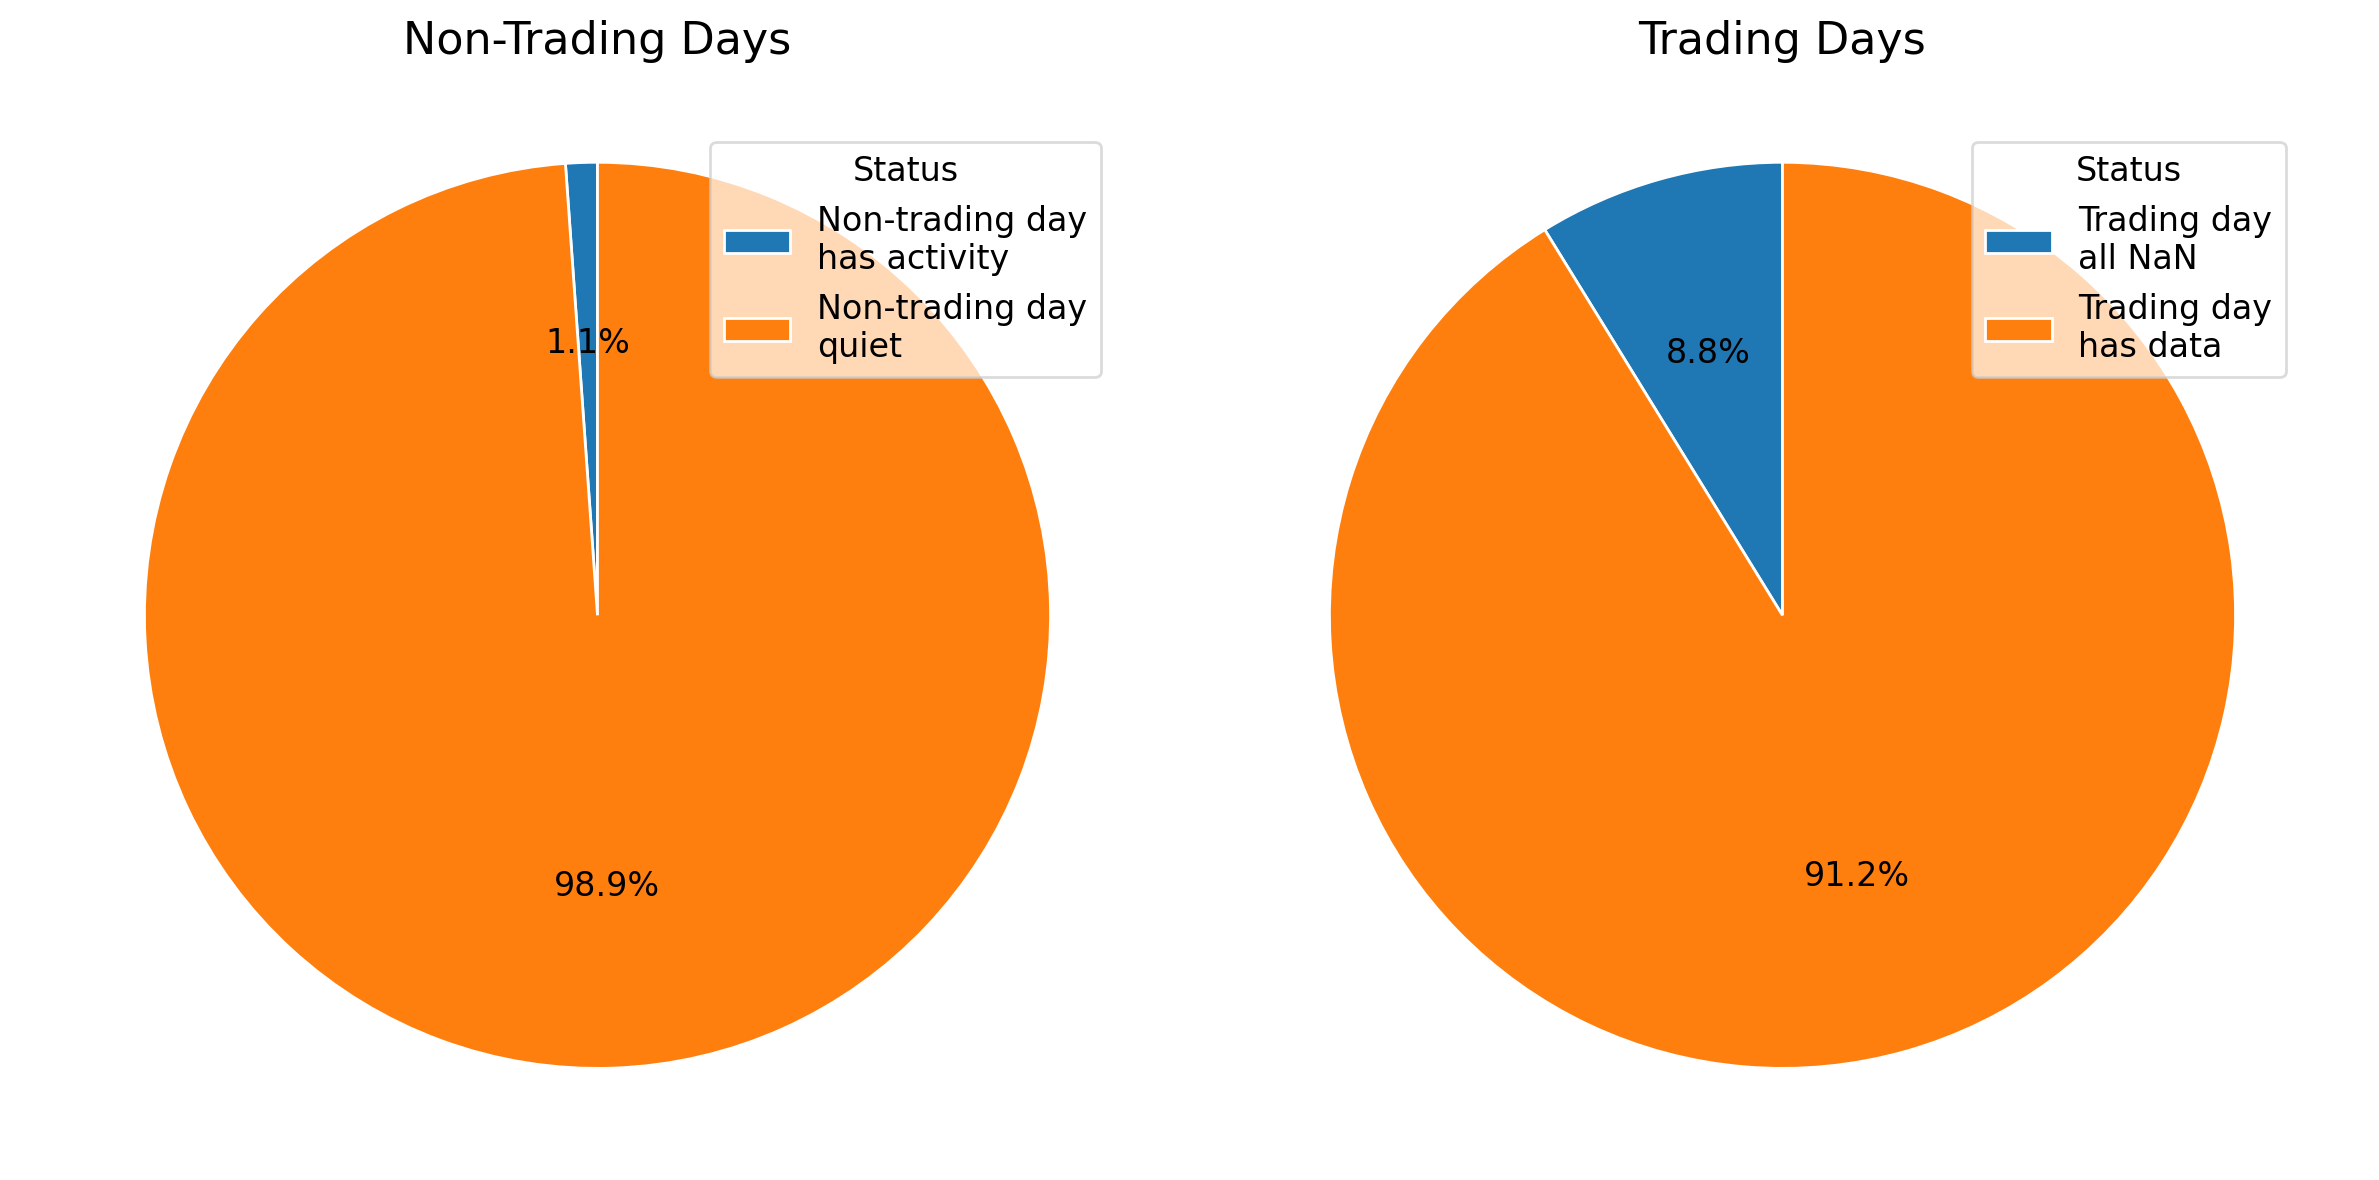

In [24]:
import matplotlib.pyplot as plt

# replace with your actual computed values
sizes_non_trade = [
    num_non_trading_days_with_activity,
    len(df_non_trading) - num_non_trading_days_with_activity
]
sizes_trade = [
    num_trading_days_all_nan,
    len(df_trading) - num_trading_days_all_nan
]
labels_non_trade = ["Non-trading day\nhas activity", "Non-trading day\nquiet"]
labels_trade     = ["Trading day\nall NaN", "Trading day\nhas data"]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=200)

# Left pie – Non-trading days
wedges_nt, texts_nt, autotxts_nt = axes[0].pie(
    sizes_non_trade,
    startangle=90,
    autopct="%1.1f%%",
    textprops={"fontsize": 12},
    wedgeprops={"edgecolor": "white"}
)
axes[0].axis("equal")
axes[0].set_title("Non-Trading Days", fontsize=16)
axes[0].legend(
    wedges_nt,
    labels_non_trade,
    title="Status",
    title_fontsize=12,
    fontsize=12,
    loc="upper right",
    framealpha=0.7,
    bbox_to_anchor=(0.95, 0.95)
)

# Right pie – Trading days
wedges_t, texts_t, autotxts_t = axes[1].pie(
    sizes_trade,
    startangle=90,
    autopct="%1.1f%%",
    textprops={"fontsize": 12},
    wedgeprops={"edgecolor": "white"}
)
axes[1].axis("equal")
axes[1].set_title("Trading Days", fontsize=16)
axes[1].legend(
    wedges_t,
    labels_trade,
    title="Status",
    title_fontsize=12,
    fontsize=12,
    loc="upper right",
    framealpha=0.7,
    bbox_to_anchor=(0.95, 0.95)
)

plt.tight_layout()
plt.show()


### Fill Missing Values

We assume the calendar are basically correct.
- For non-trading days, there are 16 days with activity.
  - Ignore for now.
- For trading days, there are 230 days with all NaN values.
  - Reguard as open market but no trade.
  
**Missing-Value Imputation Strategy for GDEA Raw Panel**

1. **Generate Flags**
   * `is_open` = calendar day $\in$ XSHG session list.  
   * `is_quiet` = `is_open` & `volume_tons` is NaN.  
   * `has_trade` = `volume_tons.notna()`.

2. **Activity Columns** (`volume_tons`, `turnover_cny`)
   * If `is_quiet`: set **0.0**.  
   * If `is_open == 0`: leave NaN.  
   * Else: keep original numeric values.

3. **Price Columns** (`close`, `vwap`)
   * Forward-fill **one trading day only** within `is_open` blocks.  
   * Create Boolean flags `close_carried`, `vwap_carried` (current == previous).

4. **Cumulative Turnover** (`cum_turnover_cny`)
   * Forward-fill without limit;

5. **Clean-up**
   * Drop rows that still have NaN prices (market never traded yet).  
   * Ensure all numeric columns are `float64`; drop duplicate turnover column.

6. **Persist & Document**
   * Save as `02_GDEA_clean.parquet`.  
   * Write `README.md` noting calendar assumption, rules above, and row counts for each flag.

#### 1. Generate flags

In [25]:

df_restored["is_open"] = df_restored["is_trading_day"]
df_restored["is_quiet"] = df_restored["is_open"] & df_restored[["volume_tons"]].isna().all(axis=1)
df_restored["has_trade"] = df_restored["volume_tons"].notna()

# Check if the flags are generated correctly
# Num True/False in each flag
print(df_restored["is_open"].value_counts())
print(df_restored["is_quiet"].value_counts())
print(df_restored["has_trade"].value_counts())

is_open
True     2638
False    1329
Name: count, dtype: int64
is_quiet
False    3735
True      232
Name: count, dtype: int64
has_trade
True     2421
False    1546
Name: count, dtype: int64


In [26]:
df_restored.head()

,close,vwap,volume_tons,turnover_cny,cum_turnover_cny,is_trading_day,is_open,is_quiet,has_trade
date,,,,,,,,,
2014-06-27,68.00,68.00,6.0,408.00,34705338.01,True,True,False,True
2014-06-28,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2014-06-29,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2014-06-30,62.41,62.41,8.0,499.29,34705837.30,True,True,False,True
2014-07-01,58.00,58.00,2776.0,161018.65,34866855.95,True,True,False,True


#### 2. Activity Columns

In [27]:
# Fill volume_tons with 0.0 when is_open is True and volume_tons is NaN
df_restored.loc[df_restored["is_open"] & df_restored["volume_tons"].isna(), "volume_tons"] = 0.0

# Fill turnover_cny with 0.0 when is_open is True and turnover_cny is NaN
df_restored.loc[df_restored["is_open"] & df_restored["turnover_cny"].isna(), "turnover_cny"] = 0.0

# Check if all open day volume_tons and turnover_cny are filled
print(f"Unfilled volume_tons: {df_restored[df_restored['is_open'] & df_restored['volume_tons'].isna()].shape[0]}")
print(f"Unfilled turnover_cny: {df_restored[df_restored['is_open'] & df_restored['turnover_cny'].isna()].shape[0]}")

Unfilled volume_tons: 0
Unfilled turnover_cny: 0


#### 3. Price Columns

In [28]:
# mask of open days where price was originally NaN
orig_missing = df_restored['is_open'] & df_restored['close'].isna()

price_cols = ["close", "vwap"]

df_restored[price_cols] = df_restored.groupby(df_restored["is_open"])[price_cols].transform(lambda x: x.ffill(limit=1))

# Check if all price columns that should be filled are filled

print("Unfilled price values on open days:")
for col in price_cols:
    unfilled = df_restored[df_restored['is_open'] & df_restored[col].isna()].shape[0]
    print(f"{col}: {unfilled}")

# among the original missing days, how many got filled?
filled_first = (orig_missing & df['close'].notna()).sum()
print("First-day quiet fills (close):", filled_first)

# among the original missing days, how many still remain NaN?
still_missing = (orig_missing & df['close'].isna()).sum()
print("Remaining NaNs among orig-missing (close):", still_missing)

# a day that was not originally missing but now is non-NaN
extra_filled = (
    (~orig_missing)               # wasn’t target for fill
    & df_restored['is_open']               # open day
    & df_restored['close'].notna()         # ended up non-NaN
    & df_restored['close'].isna() # but started as NaN (catches only unintended)
).sum()
print("Extra fills:", extra_filled)

Unfilled price values on open days:
close: 125
vwap: 124
First-day quiet fills (close): 0
Remaining NaNs among orig-missing (close): 235
Extra fills: 0


#### 4. Cumulative Turnover

In [29]:
# Forward-fill cumulative turnover, just forward fill nan
df_restored["cum_turnover_cny"] = df_restored["cum_turnover_cny"].ffill()

# Check if all cumulative turnover is filled
print(f"Unfilled cumulative turnover: {df_restored[df_restored['is_open'] & df_restored['cum_turnover_cny'].isna()].shape[0]}")

Unfilled cumulative turnover: 0


#### 5. Clean-up

In [30]:
# Drop `is_trading_day`
df_restored = df_restored.drop(columns=["is_trading_day"])
df_restored.head()

,close,vwap,volume_tons,turnover_cny,cum_turnover_cny,is_open,is_quiet,has_trade
date,,,,,,,,
2014-06-27,68.00,68.00,6.0,408.00,34705338.01,True,False,True
2014-06-28,NaN,NaN,NaN,NaN,34705338.01,False,False,False
2014-06-29,NaN,NaN,NaN,NaN,34705338.01,False,False,False
2014-06-30,62.41,62.41,8.0,499.29,34705837.30,True,False,True
2014-07-01,58.00,58.00,2776.0,161018.65,34866855.95,True,False,True


#### 6. Persist & Document

In [31]:
# Save as processed data to "../../02_Data_Processed/Carbon_Cleaned_Aligned"
df_restored.to_csv("../../02_Data_Processed/Carbon_Cleaned_Aligned/GDEA_processed.csv")
df_restored.to_parquet("../../02_Data_Processed/Carbon_Cleaned_Aligned/GDEA_processed.parquet")